# Demonstration for Lecture 4

But given in lecture 5

Subject: Benign overfitting

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import pinvh

# Setting a random seed lets us exactly replicate our results from one run to another.
np.random.seed(333)

A slightly different DGP than last time. Here, we have:

$$
x \sim Unif(0, \pi)\\
\mu = \cos(3x)\\
y \sim N(\mu, 0.4)
$$

In [2]:
def dgp(n):
    x = np.random.uniform(low=0, high=np.pi, size = n)
    y = np.cos(3 * x) + np.random.normal(scale = 0.4, size = n)
    return x, y

def true(n):
    x = np.linspace(0, np.pi, num = n)
    y = np.cos(3 * x)
    return x, y

And we can grab our data the same way as before. We'll also pull a grid of points from the noiseless process for plotting purposes.

In [3]:
x_train, y_train = dgp(n = 60)
x_grid, y_true = true(10000)

Plot the raw data and the true function in red.

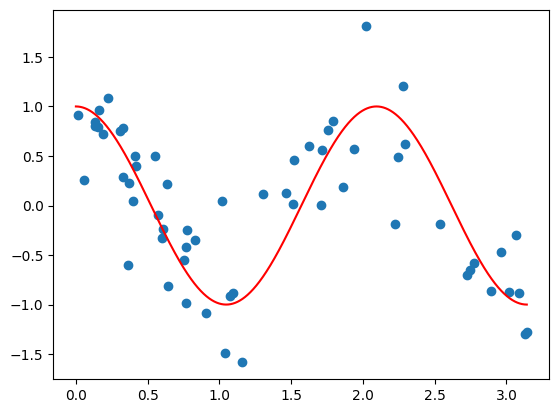

In [4]:
plt.scatter(x_train, y_train)
plt.plot(x_grid, y_true, '-', color='red');

This time, our feature expansion will be cosines of different frequency. As the dimension increases, we incorporate increasingly high frequency cosines.

You can think about our task here as approximating an unknown function ($\cos(3x)$) with a [Fourier series](https://en.wikipedia.org/wiki/Fourier_series#Common_forms_of_the_Fourier_series), but you're also welcome to just treat this as a black box.

In [5]:
def create_feature_matrix(x, dimension):
    n = x.shape[0]
    X = np.ones(shape = (n, dimension))
    for m in range(1, dimension + 1):
        X[:, m - 1] = np.cos(m * x)
    return np.hstack((np.ones((n, 1)), X))

This time, we're going to write a function to estimate OLS a bit smarter than we did before.

We're going to use the [Singular Value Decomposition](https://en.wikipedia.org/wiki/Singular_value_decomposition) of our feature matrix, $X$.

$$
U, D, V^\top = svd(X)
$$

Then, we can write our in-sample predictions from OLS, $X\hat{\beta}$ in terms of our SVD as $UU^\top y$.

For an out-of-sample feature matrix $\tilde{X}$, we can do the same general math (but with fewer nice cancellations) as the following:

$$
\begin{align*}
\tilde{X}\hat{\beta} &= \tilde{X} (X^\top X)^{-1} X^\top y\\
&= \tilde{X} ((UDV^\top)^\top UDV^\top)^{-1} (UDV^\top)^\top y \\
&= \tilde{X} V (DD)^{-1} D U^\top y \\
&= \tilde{X} V D^{-1} U^\top y
\end{align*}
$$

If $p \geq n$, then we need to take the Moore-Penrose pseudoinverse by clipping all dimensions with singular value smaller than some number. We do that by making all elements of $D$ with value less than some constant equal to zero. I call this parameter `atol` for "absolute tolerance" following [SciPy's implementation](https://docs.scipy.org/doc/scipy/reference/generated/scipy.linalg.pinv.html#scipy.linalg.pinv).

In [6]:
def ols_predict(X, y, X_test = None, atol=1e-8):
    # Note: np.linalg.svd returns V.T, so we take the transpose to get V
    p = X.shape[1]
    n = X.shape[0]
    U, D, V = np.linalg.svd(X, full_matrices = False)
    if n > p:
        yhat = U @ U.T @ y
        if X_test is not None:
            yhat_test = X_test @ V.T @ np.diag(1 / D) @ U.T @ y
        else:
            yhat_test = None
    else:
        ok = D > atol
        Uok = U[:, ok]
        Vok = V[ok, :]
        yhat = Uok @ Uok.T @ y
        if X_test is not None:
            yhat_test = X_test @ Vok.T @ np.diag(1 / D[ok]) @ Uok.T @ y
        else:
            yhat_test = None
    return yhat, yhat_test

Check that this algorithm replicates our expectations. We expect it to be numerically equal to what we get if we directly calculate $(X^\top X)^{-1} X^\top y$.

In [7]:
X_train = create_feature_matrix(x_train, 10)
X_grid = create_feature_matrix(x_grid, 10)
yhat, yhat_grid = ols_predict(X_train, y_train, X_grid) 
err = np.abs(yhat_grid - (X_grid @ np.linalg.inv(X_train.T @ X_train) @ X_train.T @ y_train))
np.min(err), np.max(err)

(0.0, 5.88418203051333e-15)

Likewise, we should be pretty close in the over-parameterized case to what we'd get by explicitly taking the pseudo-inverse. Note that there's some slippage here because of the alternative ways that zeroes get truncated in the two methods. But it's close enough for government work.

In [8]:
X_train = create_feature_matrix(x_train, 100)
X_grid = create_feature_matrix(x_grid, 100)
yhat, yhat_grid = ols_predict(X_train, y_train, X_grid) 
err = np.abs(yhat_grid - (X_grid @ pinvh(X_train.T @ X_train, atol = 1e-8, rtol=0) @ X_train.T @ y_train))
np.min(err), np.max(err)

(1.4588330543574557e-13, 5.826285587318125e-08)

Now we can see how well we do with a small model and plot our predictions.

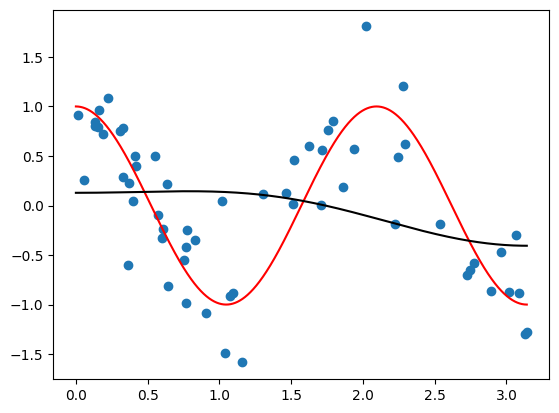

In [9]:
X_train = create_feature_matrix(x_train, 2)
X_grid = create_feature_matrix(x_grid, 2)
yhat_train, yhat_grid = ols_predict(X_train, y_train, X_grid)

plt.scatter(x_train, y_train)
plt.plot(x_grid, y_true, '-', color='red')
plt.plot(x_grid, yhat_grid, '-', color='black');

If we use a slightly larger expansion, we can do very well! This shouldn't be surprising, since our features are $\cos(m x)$ for a range of positive integers $m$, and our true function is $\cos(3x)$.

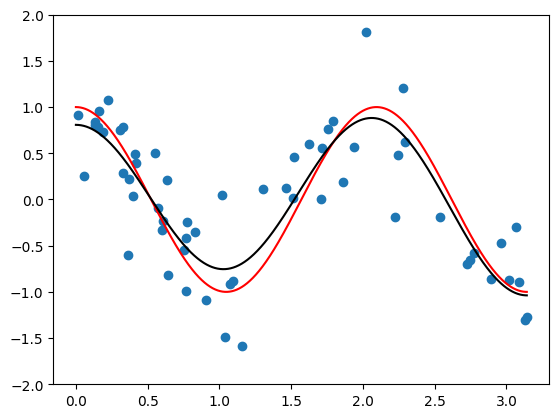

In [10]:
X_train = create_feature_matrix(x_train, 3)
X_grid = create_feature_matrix(x_grid, 3)
yhat_train, yhat_grid = ols_predict(X_train, y_train, X_grid)

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.scatter(x_train, y_train)
ax.plot(x_grid, y_true, '-', color='red')
ax.plot(x_grid, yhat_grid, '-', color='black')
ax.set_ylim(-2, 2);

What about if we throw a bunch of features in there? Since we don't a-priori know the right function.

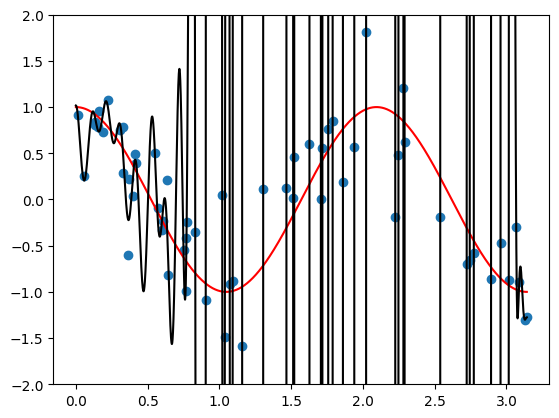

In [11]:
X_train = create_feature_matrix(x_train, 50)
X_grid = create_feature_matrix(x_grid, 50)
yhat_train, yhat_grid = ols_predict(X_train, y_train, X_grid)

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.scatter(x_train, y_train)
ax.plot(x_grid, y_true, '-', color='red')
ax.plot(x_grid, yhat_grid, '-', color='black')
ax.set_ylim(-2, 2);

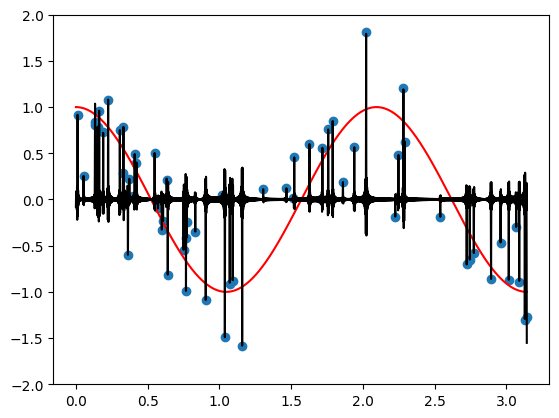

In [12]:
X_train = create_feature_matrix(x_train, 2000)
X_grid = create_feature_matrix(x_grid, 2000)
yhat_train, yhat_grid = ols_predict(X_train, y_train, X_grid)

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.scatter(x_train, y_train)
ax.plot(x_grid, y_true, '-', color='red')
ax.plot(x_grid, yhat_grid, '-', color='black')
ax.set_ylim(-2, 2);

As the number of features gets really large, we start (i) perfectly interpolating the points in the training data and (ii) predicting zero everywhere else.

This is because of a funny property of high frequency trigonometric functions: given a single parameter, if we put no restrictions on $m$, there is some value that perfect interpolates our training points. See the lecture slides for an example (showing that VC dimension is not equivalent to the number of parameters).

Now we want to look at the SVD of our training data. What do the singular values look like? We can see that they mostly have singular values around 1000. They're quite clustered together.

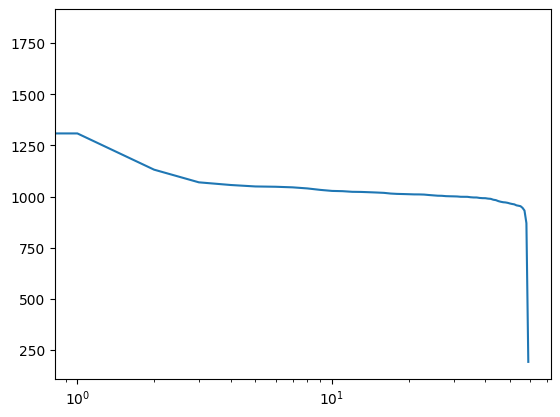

In [13]:
X_train = create_feature_matrix(x_train, 2000)
D = np.linalg.svd(X_train, compute_uv = False)

plt.plot(np.power(D, 2))
plt.xscale('log');

What happens if we clip the SVD pretty aggressively?

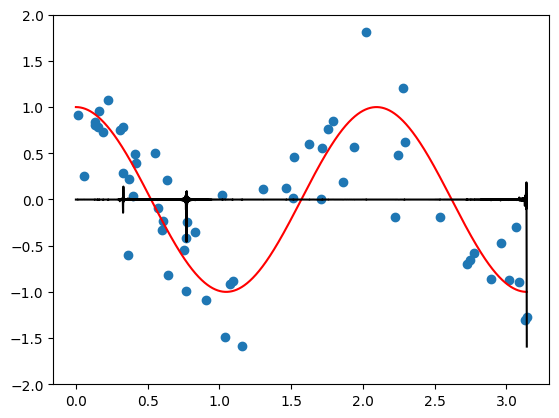

In [14]:
X_train = create_feature_matrix(x_train, 2000)
X_grid = create_feature_matrix(x_grid, 2000)
yhat_train, yhat_grid = ols_predict(X_train, y_train, X_grid, atol = np.sqrt(1100))

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.scatter(x_train, y_train)
ax.plot(x_grid, y_true, '-', color='red')
ax.plot(x_grid, yhat_grid, '-', color='black')
ax.set_ylim(-2, 2);

We no longer interpolate and we get a function that's even closer to zero than it was before.

We can verify that the singular values are the same as we saw above if we look at the SVD of $X^\top X$. Of course, we know that $svd(X^\top X) = V D^2 V^\top$.

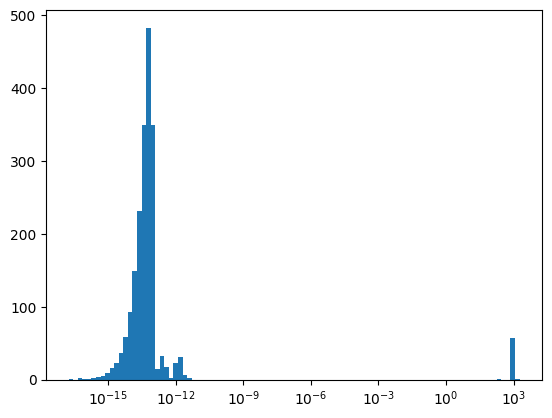

In [15]:
X_train = create_feature_matrix(x_train, 2000)
D = np.linalg.svd(X_train.T @ X_train, compute_uv = False)
logbins = np.logspace(np.log10(np.min(D)),np.log10(np.max(D)),100)

plt.hist(D, bins=logbins)
plt.xscale('log');

We can define a new feature matrix which weights up the lower frequency (smaller $m$) features more than high frequency (higher $m$) ones. This will result in a different SVD which will focus more strongly on these low-frequency dimensions (i.e. the singular values for those dimensions will be larger).

In [16]:
def create_weighted_feature_matrix(x, dimension):
    n = x.shape[0]
    X = np.ones(shape = (n, dimension))
    for m in range(1, dimension + 1):
        X[:, m - 1] = np.cos(m * x) / m
    return np.hstack((np.ones((n, 1)), X))

Once we reweight these features, we see that there's more variation in singular values.

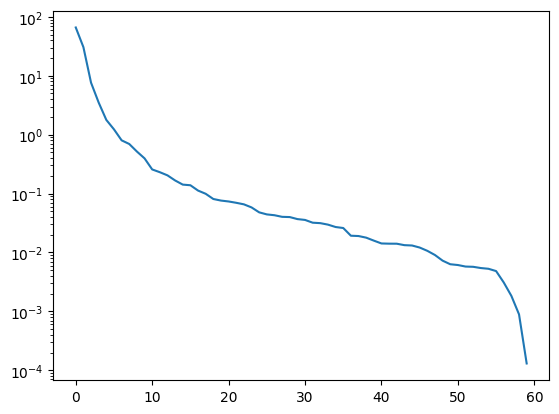

In [17]:
X_train = create_weighted_feature_matrix(x_train, 2000)
D = np.power(np.linalg.svd(X_train, compute_uv = False), 2)

plt.plot(D)
plt.yscale('log');

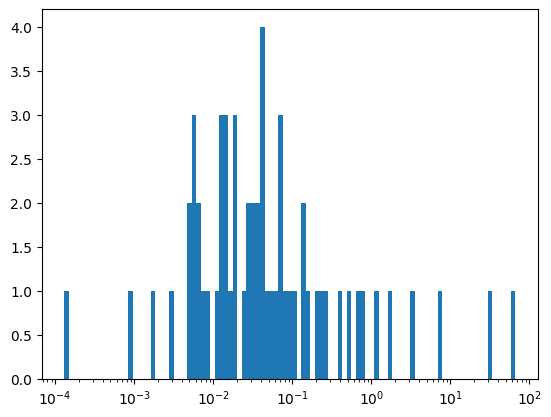

In [18]:
#D = np.linalg.svd(X_train, compute_uv = False)
logbins = np.logspace(np.log10(np.min(D)),np.log10(np.max(D)),100)

plt.hist(D, bins=logbins)
plt.xscale('log');

Once again, this matches what we see if we take the SVD directly on $X^\top X$, as we expect. Note the large peak of numeric (but not exact) zeroes. By the properties of SVD, we know that these must be exactly equal to zero.

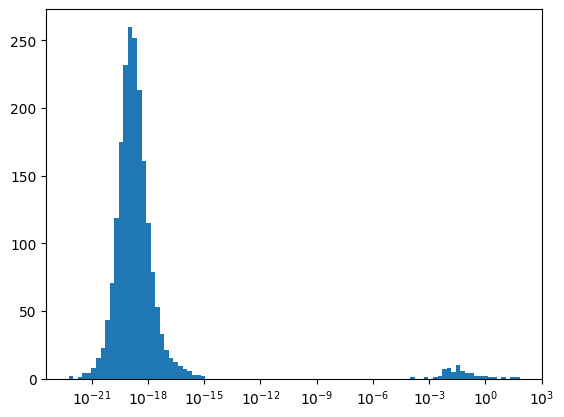

In [19]:
X_train = create_weighted_feature_matrix(x_train, 2000)
D = np.linalg.svd(X_train.T @ X_train, compute_uv = False)
logbins = np.logspace(np.log10(np.min(D)),np.log10(np.max(D)),100)

plt.hist(D, bins=logbins)
plt.xscale('log');

In [20]:
X_train = create_weighted_feature_matrix(x_train, 2000)
D = np.linalg.svd(X_train, compute_uv = False)

D

array([8.11902696, 5.52690595, 2.75852885, 1.87016939, 1.33305949,
       1.10875093, 0.89474572, 0.83297139, 0.71873704, 0.62895801,
       0.50657959, 0.47989917, 0.45128303, 0.40840433, 0.37664439,
       0.37194   , 0.33519515, 0.31477837, 0.28430387, 0.27568252,
       0.27089678, 0.26395767, 0.25613354, 0.24118732, 0.21900027,
       0.21039934, 0.20703887, 0.20065134, 0.19972025, 0.19199574,
       0.18885378, 0.17893372, 0.17734675, 0.17229246, 0.16443849,
       0.16124416, 0.13871922, 0.13786043, 0.13356393, 0.12602935,
       0.11924273, 0.11877016, 0.11867192, 0.11535538, 0.11460557,
       0.11009613, 0.10326065, 0.09514175, 0.08521707, 0.07944342,
       0.07823483, 0.07593617, 0.07556569, 0.07376288, 0.07270326,
       0.0695098 , 0.05563223, 0.04278213, 0.02982844, 0.01142493])

That all prepares us to estimate this grossly overparameterized model again, where we will lean more heavily on the low-frequency features.

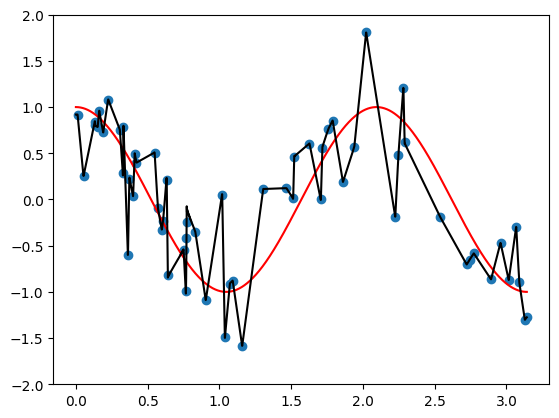

In [21]:
X_train = create_weighted_feature_matrix(x_train, 2000)
X_grid = create_weighted_feature_matrix(x_grid, 2000)
yhat_train, yhat_grid = ols_predict(X_train, y_train, X_grid)

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.scatter(x_train, y_train)
ax.plot(x_grid, y_true, '-', color='red')
ax.plot(x_grid, yhat_grid, '-', color='black')
ax.set_ylim(-2, 2);

Let's draw a test set so we can evaluate our error properties based on the number of features estimated.

In [22]:
x_test, y_test = dgp(n = 1000)

In [23]:
results = []
num_features_to_test = np.concatenate((np.arange(1, 50, step=1), np.arange(50, 2000, step = 10)))

# Collect MSE for only using a constant term
this_result = {}
this_result["num_features"] = 0
this_result["weighted_mse"] = np.average(np.power(y_test - np.average(y_train), 2))
this_result["unweighted_mse"] = np.average(np.power(y_test - np.average(y_train), 2))
results.append(this_result)

for num_features in num_features_to_test:
    X_train = create_weighted_feature_matrix(x_train, num_features)
    X_test = create_weighted_feature_matrix(x_test, num_features)
    yhat_train, yhat_test = ols_predict(X_train, y_train, X_test)
    this_result = {}
    this_result["num_features"] = num_features
    this_result["weighted_mse"] = np.average(np.power(y_test - yhat_test, 2))

    X_train = create_feature_matrix(x_train, num_features)
    X_test = create_feature_matrix(x_test, num_features)
    yhat_train, yhat_test = ols_predict(X_train, y_train, X_test)
    this_result["unweighted_mse"] = np.average(np.power(y_test - yhat_test, 2))
    results.append(this_result)

result_df = pd.DataFrame.from_records(results)

As we expect, we get very low error once we hit 3 features.

In [24]:
result_df.head(5)

,num_features,weighted_mse,unweighted_mse
0,0,0.648657,0.648657
1,1,0.689630,0.689630
2,2,0.701024,0.701024
3,3,0.171447,0.171447
4,4,0.186488,0.186488


But surprisingly, we also see fairly low error for the weighted-features model with a ton of features!

In [25]:
result_df.tail(5)

,num_features,weighted_mse,unweighted_mse
240,1950,0.320189,0.632628
241,1960,0.320150,0.632639
242,1970,0.320156,0.632439
243,1980,0.320066,0.632379
244,1990,0.320057,0.632671


We can look at this as a plot as well.

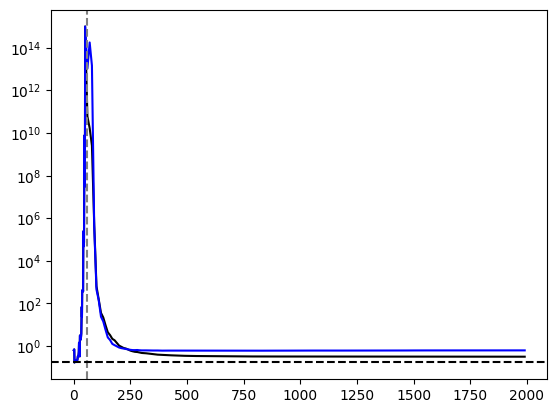

In [26]:
best_mse = result_df.loc[result_df.num_features == 3, "weighted_mse"].item()
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.plot(result_df["num_features"], result_df["weighted_mse"], "-", color = "black")
ax.plot(result_df["num_features"], result_df["unweighted_mse"], "-", color = "blue")
# ax.set_xlim(0, 20)
# ax.set_ylim(0, 20);
ax.axvline(x=60, linestyle="--", color="grey")
ax.axhline(y=best_mse, linestyle="--", color="black")
ax.set_yscale('log');

And we can zoom in on the relevant part of the y-axis.

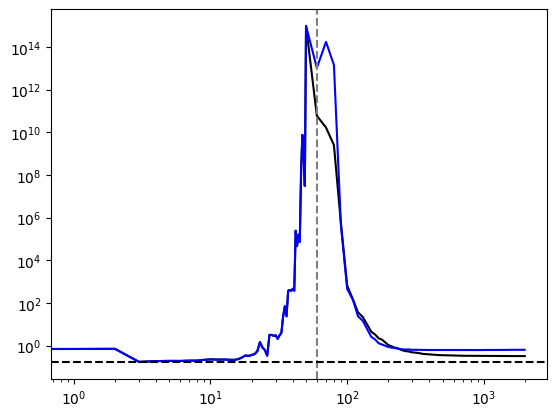

In [27]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.plot(result_df["num_features"], result_df["weighted_mse"], "-", color = "black")
ax.plot(result_df["num_features"], result_df["unweighted_mse"], "-", color = "blue")
#ax.set_ylim(0, 2)
ax.set_xscale("log")
ax.set_yscale("log")
ax.axvline(x=60, linestyle="--", color="grey")
ax.axhline(y=best_mse, linestyle="--", color="black");

Long story short, we have now witnessed "benign overfitting", which appears to "break" the classical bias-variance tradeoff. The error skyrockets around the interpolation threshold, but then settles back down into a low-error regime after the dimensionality gets sufficiently high again. 

The lecture slides demonstrate that generalization error for this $p \gg n$ regime is characterized by:

$$
\frac{\sigma^2}{c} \left(\frac{k^*}{n} + \frac{n}{R_k^*(\Sigma)}\right)
$$

Of course, if it were characterized by the ambient dimensionality ($p$), then the performance would be truly poor, indeed.

If you want to read more on this, a few papers are listed below, but they are very challenging and you probably won't be able to understand a lot of them. These are modern theoretical ML papers and there is zero expectation for you to read them or necessity to do so to ace this class.

- Bartlett, Long, Lugosi and Tsigler. (2020) "Benign overfitting in linear regression" PNAS https://doi.org/10.1073/pnas.1907378117
- Tsigler and Bartlett (2023) "Benign overfitting in ridge regression" JMLR https://jmlr.org/papers/v24/22-1398.html

The example I've shown here comes out of the JMLR paper.